# Model Generation for GBIF Fungi Dataset

In [1]:
notebook_ver = "0.0.1"

## References
* [Transfer Learning with Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)
* [`tf.data`: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data?hl=en)

---

## Setup

In [2]:
import numpy as np
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow_hub as hub
from keras.utils.layer_utils import count_params

from sklearn.model_selection import train_test_split
import json
import time
import datetime
import logging

# Set logging to output INFO level to standard output
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

# Set tf logging level to WARN
tf.get_logger().setLevel( 'WARN' )

AUTOTUNE = tf.data.AUTOTUNE

### Limit GPU memory allocation
[Limiting GPU Memory Growth](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth)

In [3]:
def limit_memory_growth(limit=True):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, limit)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [4]:
limit_memory_growth()

1 Physical GPUs, 1 Logical GPUs


### Multi-GPU strategy

In [5]:
# strategy = tf.distribute.MirroredStrategy( devices = [ "/gpu:0", "/gpu:1" ] )
strategy = tf.distribute.MirroredStrategy()

---

## `runs` DataFrame
Keeps track of all runs performed

In [6]:
runs_dir = '/media/data/runs'
runs_hdf = 'runs.h5'
runs_hdf_key = 'runs'

## `run` Dictionary

The `run` dictionary will keep track of this run's user-defined hyperparameters as well as generated parameters such as random seeds and file paths. This information will be saved in the `runs_hdf` specified above.

In [7]:
run = {}
# use a formatted timestamp as the run's ID
run['id'] = datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
run['notebook_ver'] = notebook_ver

In [8]:
# the path of the directory where this run's files will be stored (metadata, saved model(s), etc.)
run['path'] = os.path.join( runs_dir, str(run['id']) )
run['path']

'/media/data/runs/2023_03_19-15_07_43'

In [9]:
# Will overwrite existing run in dataframe with the same id
# - allows updating as we go
def save_run_metadata(
    run,
    index = 'id',
):
    # create df from run using json_normalize to flatten dict
    run_df = pd.json_normalize( run )
    run_df = run_df.set_index( index )

    # create runs_df if it doesn't exist
    runs_hdf_path = os.path.join( runs_dir, runs_hdf )
    if ( not os.path.isfile( runs_hdf_path ) ):
        pd.DataFrame().to_hdf( runs_hdf_path, runs_hdf_key )
    
    # read in the runs_hdf
    runs_df = pd.read_hdf(
        runs_hdf_path,
        runs_hdf_key,
    )
    
    # If a row for this run already exists, remove it
    if ( run[ index ] in runs_df.index ):
        runs_df = runs_df.drop( run[ index ] )
 
    # Add the updated data
    runs_df = pd.concat(
        [ runs_df, run_df ],
    )
    
    # save to file
    runs_df.to_hdf( runs_hdf_path, runs_hdf_key )


In [10]:
def print_run_metadata( run ):
    print( json.dumps( run, indent = 3 ) )

In [11]:
# Make sure the run path doesn't already exist and create it
if (os.path.exists( run['path'] )):
    logging.warn("Run path already exists!!")
    logging.warn(" Overwriting: %s" % run['path'])
else:
    os.makedirs( run['path'] )

In [12]:
print_run_metadata( run )

{
   "id": "2023_03_19-15_07_43",
   "notebook_ver": "0.0.1",
   "path": "/media/data/runs/2023_03_19-15_07_43"
}


---

## Enumerate Available Base Models

In [13]:
class BaseModel:

    def __init__(
        self,
        source,
        input_dim,
        preprocessor,
    ):
        self.source = source
        self.input_dim = input_dim
        self.preprocessor = preprocessor
    
base_models = {
    'MobileNet_v2': BaseModel(
        source = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4',
        input_dim = 224,
        # https://www.tensorflow.org/hub/common_signatures/images#input
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        preprocessor = tf.keras.applications.mobilenet_v2.preprocess_input,
    ),

    'Inception_v3': BaseModel(
        source = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4',
        input_dim = 299,
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        preprocessor = tf.keras.applications.inception_v3.preprocess_input,
    ),

    'Inception_v3_iNaturalist': BaseModel(
        source = 'https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5',
        input_dim = 299,
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        preprocessor = tf.keras.applications.inception_v3.preprocess_input,
    ),

    'Xception': BaseModel(
        source = tf.keras.applications.Xception,
        input_dim = 299,
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        preprocessor = tf.keras.applications.xception.preprocess_input,
    ),

    'ResNet101': BaseModel(
        source = tf.keras.applications.resnet.ResNet101,
        input_dim = 224,
        preprocessor = tf.keras.applications.resnet50.preprocess_input,
    ),

    'ResNet50': BaseModel(
        source = tf.keras.applications.ResNet50,
        input_dim = 224,
        preprocessor = tf.keras.applications.resnet50.preprocess_input,
    ),

    'Inception_ResNet_v2': BaseModel(
        source = tf.keras.applications.InceptionResNetV2,
        input_dim = 299,
        preprocessor = tf.keras.applications.inception_resnet_v2.preprocess_input,
    ),

    'EfficientNet_v2': BaseModel(
        source = tf.keras.applications.efficientnet_v2.EfficientNetV2B0,
        input_dim = 224,
        # The preprocessing logic has been included in the EfficientNetV2
        # model implementation. Users are no longer required to call this
        # method to normalize the input data. This method does nothing and
        # only kept as a placeholder to align the API surface between old
        # and new version of model.
        preprocessor = tf.keras.applications.efficientnet_v2.preprocess_input,
    ),
}


## Enumerate Available Datasets

In [14]:
class DatasetHDFSource:
    
    def __init__(
        self,
        path,
        key,
        col_filename = 'filename',
        col_label = 'label',
    ):
        self.path = path
        self.key = key
        self.col_filename = col_filename
        self.col_label = col_label

datasets = {
    'gbif': DatasetHDFSource(
        '/media/data/gbif/clean_data.h5',
        'media_merged_filtered-by-species_350pt',
        col_label = 'acceptedScientificName',
    ),
    'cub': DatasetHDFSource(
        '/media/data/cub/cub.h5',
        'cub',
        col_filename = 'file_path',
        col_label = 'class_name',
    ),
}
        

### Hyper-parameters

In [15]:
run.update( {
    # "id": "2023_03_19-14_13_29",
    # "notebook_ver": "0.0.1",
    # "path": "/media/data/runs/2023_03_19-14_13_29",
    "batch_size": 64,
    "max_epochs": 50,
    "label_smoothing": 0.1,
    "model": {
        "learning_rate": 0.0001, # Adam Optimizer
        "classifier": {
            "dropout": 0.33,
            "output_logits": True
        },
        "base": "Inception_v3_iNaturalist"
    },
    "dataset": {
        "downsample": "min",
        "source": "cub",
        "split_test": 0.05,
        "split_val": 0.1,
        # "seed_split_test": 2907756077,
        # "seed_split_val": 973073386,
        # "seed_shuffle": 7296619955565341716
    }, # run['callbacks']['early_stopping']['restore_best_weights'],
    "callbacks": {
        "early_stopping": {
            "restore_best_weights": True,
        }
    }
    # "label_mapping_path": "/media/data/runs/2023_03_19-14_13_29/label_mapping.json"
} )

# TODO: allow loading of model weights from previous run
load_weights = None

In [16]:
save_run_metadata( run )

/tmp/ipykernel_56896/3436063570.py:32: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['notebook_ver', 'path', 'label_mapping_path',
       'model.classifier.output_logits', 'model.base', 'dataset.downsample',
       'dataset.source', 'callbacks.early_stopping.restore_best_weights'],
      dtype='object')]

  runs_df.to_hdf( runs_hdf_path, runs_hdf_key )


### Timer

In [17]:
timer = {}
timer['start'] = time.perf_counter()

---

In [18]:
# Read in source dataframe
ds_df = pd.read_hdf(
    datasets[ run['dataset']['source'] ].path,
    datasets[ run['dataset']['source'] ].key,
)

### Dataset Information

In [19]:
ds_classes = ds_df[ datasets[ run['dataset']['source'] ].col_label ].unique().tolist()
print('Label count: %d' % len(ds_classes))
print('Datapoint count: %d' % len(ds_df))

Label count: 200
Datapoint count: 11788


In [20]:
def save_label_mapping(
    label_mapping,
    file_path = './label_mapping.json',
):
    with open( file_path, 'w' ) as f:
        json.dump( label_mapping, f, indent = 3 )

In [21]:
run['label_mapping_path'] = os.path.join( run['path'], 'label_mapping.json' )
save_label_mapping(
    ds_classes,
    file_path = run['label_mapping_path'],
)

In [22]:
ds_df_label_vc = ds_df[ datasets[ run['dataset']['source'] ].col_label ].value_counts()
ds_df_label_vc = ds_df_label_vc.sort_values( ascending = False )

In [23]:
ds_df_label_vc.head()

Black footed Albatross    60
Red eyed Vireo            60
Rose breasted Grosbeak    60
Pine Grosbeak             60
Evening Grosbeak          60
Name: class_name, dtype: int64

In [24]:
ds_df_label_vc.tail()

Whip poor Will       49
Rhinoceros Auklet    48
Spotted Catbird      45
Crested Auklet       44
Least Auklet         41
Name: class_name, dtype: int64

<Axes: >

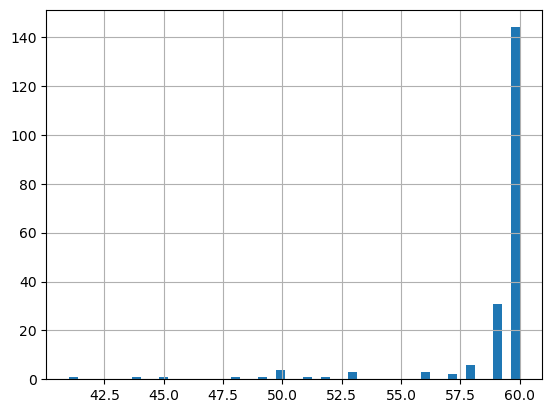

In [25]:
ds_df_label_vc.hist( bins = 50 )

Most classes have 350 datapoints because I *thought* I had downsampled the datasets with more than 350 datapoints down to 350 but it looks like there are some that were not affected by the transformation I performed. There are some classes with more than 350 datapoints somehow. Regardless, we will be downsampling them all to the lowest value_count (101)...

### Dataset Transformation
(downsample, upsample, etc.)

In [26]:
# Downsample to equal number of samples per class if downsample param is set
if ( run['dataset']['downsample'] ):
    # if downsample param is 'min', downsample all classes to the same number of
    # samples as the class with the least samples
    if ( run['dataset']['downsample'] == 'min' ):
        ds_df_label_vc_min = ds_df_label_vc.min()
        print('Downsampling to least number of samples per class: %d' % ds_df_label_vc_min)
    else:
        # manual override
        if ( run['dataset']['downsample'] > 0 ):
            print( 'Overriding samples per class to: %d' % run['dataset']['downsample'] )
            ds_df_label_vc_min = run['dataset']['downsample']
        else: raise Exception("dataset downsample invalid")
    
    # downsample based on 
    ds_df_trans = ds_df.groupby( by = datasets[ run['dataset']['source'] ].col_label ).sample( n = ds_df_label_vc_min )
    ds_df_trans[ datasets[ run['dataset']['source'] ].col_label ].value_counts()

Downsampling to least number of samples per class: 41


In [27]:
# verifying that our downsampling worked - all classes should have the same value_count
ds_df_trans[ datasets[ run['dataset']['source'] ].col_label ].value_counts().value_counts()

41    200
Name: class_name, dtype: int64

We have transformed the original dataset through downsampling to produce a dataset where all classes have the same number of datapoints as the class with the least amount of datapoints.

In [28]:
print( 'New datapoint count: %d' % len(ds_df_trans) )

New datapoint count: 8200


### Train, Validation, Test Split

In [29]:
run['dataset']['split_test'] = 0.05
run['dataset']['split_val'] = 0.1

In [30]:
# generate random states for reproducability
import random

# [0, 2**32 - 1]
run['dataset']['seed_split_test'] = random.randint( 0, 2**32 - 1 )
run['dataset']['seed_split_val'] = random.randint( 0, 2**32 - 1 )

In [31]:
# test
ds_df_train, ds_df_test = train_test_split(
    ds_df_trans,
    test_size = run['dataset']['split_test'],
    stratify = ds_df_trans[[ datasets[ run['dataset']['source'] ].col_label ]],
    random_state = run['dataset']['seed_split_test'],
)

# val
ds_df_train, ds_df_val = train_test_split(
    ds_df_train,
    test_size = run['dataset']['split_val'],
    stratify = ds_df_train[[ datasets[ run['dataset']['source'] ].col_label ]],
    random_state = run['dataset']['seed_split_val'],
)

### Input Data Pipeline Generation

In [32]:
def load_image(
    filename,
):
    img_raw = tf.io.read_file( filename )
    img_tensor = tf.image.decode_image(
        img_raw,
        dtype = tf.dtypes.float32,
        channels = 3,
        expand_animations = False,
    )
    return img_tensor

In [33]:
def resize(
    img_tensor,
    input_dim,
):
    return tf.image.resize(
        img_tensor,
        [ input_dim, input_dim ],
    )

In [34]:
def preprocessing(
    img_tensor,
    preprocessor,
):
    return preprocessor( img_tensor )

In [35]:
def my_label_encoder( label, mapping ):
    one_hot = label == mapping
    label_encoded = tf.argmax( one_hot )
    return label_encoded

In [36]:
def encode_label(
    label,
    label_encoder,
):
    return label_encoder( label )

In [37]:
def data_augmentation(
    img_tensor,
    augmentation_func,
):
    return augmentation_func( img_tensor, training = True )    

In [38]:
# Augmentation function selection
augmentation_functions = [
    tf.keras.Sequential( [
        tf.keras.layers.RandomFlip( "horizontal_and_vertical" ),
        tf.keras.layers.RandomRotation( 0.2 ),
    ] )
]

In [39]:
# set augmentation_func to None if no augmentation is desired
# augmentation_func = augmentation_functions[0]
augmentation_func = None

# Determines if data augmentation should be done in the IDP or in the model
# Data augmentation will
data_augmentation_in_ds = True

In [40]:
# use a buffersize equal to the length of the dataset
shuffle_buffer_size = int( len( ds_df_train ) )

In [41]:
# generate and save the shuffle random seed
run['dataset']['seed_shuffle'] = tf.random.uniform(
    shape = (),
    dtype = tf.int64,
    maxval = tf.int64.max,
).numpy()
# make it json serializable...
run['dataset']['seed_shuffle'] = int( run['dataset']['seed_shuffle'] )

In [42]:
# Determines if preprocessing should be done in the IDP or in the model
preprocessing_in_ds = True

In [43]:
# label encoding
# (img_tensor_resized_preprocessed, label_encoded)
label_encoder = tf.keras.layers.StringLookup(
    vocabulary = ds_classes,
    # sparse = True,
    output_mode = 'one_hot',
    num_oov_indices = 0,
)

def make_idp(
    filenames,
    labels,
    input_dim,
    is_training = False,
    batch_size = 32,
    augmentation_func = None,
):
    ds = tf.data.Dataset.from_tensor_slices( (
        filenames,
        labels,
    ) )

    # if isTraining, shuffle
    if ( is_training ):
        ds = ds.shuffle(
            buffer_size = shuffle_buffer_size,
            seed = run['dataset']['seed_shuffle'],
        )

    # image loading
    # (img_tensor, label)
    ds = ds.map(
        lambda filename, label: (
            load_image(filename),
            label,
        ),
        num_parallel_calls = AUTOTUNE,
    )

    # if isTraining and augmentation_func exists, use data augmentation
    if ( is_training and data_augmentation_in_ds and augmentation_func ):
        logging.info("Adding data augmentation.")
        ds = ds.map(
            lambda img_tensor, label: (
                data_augmentation(img_tensor, augmentation_func),
                label,
            ),
            num_parallel_calls = AUTOTUNE,
        )
    
    # image resizing
    # (img_tensor_resized, label)
    ds = ds.map(
        lambda img_tensor, label: (
            resize( img_tensor, input_dim ),
            label,
        ),
        num_parallel_calls = AUTOTUNE,
    )
    
    # image preprocessing
    # (img_tensor_resized_preprocessed, label)
    if ( preprocessing_in_ds ):
        ds = ds.map(
            lambda img_tensor_resized, label: (
                preprocessing( img_tensor_resized, base_models[ run['model']['base'] ].preprocessor ),
                label,
            ),
            num_parallel_calls = AUTOTUNE,
        )


    ds = ds.map(
        lambda img_tensor_resized_preprocessed, label: (
            img_tensor_resized_preprocessed,
            encode_label( label, label_encoder ),
            # encode_label( label, lambda x: my_label_encoder( x, ds_classes ) ),
        ),
        num_parallel_calls = AUTOTUNE,
    )

    # Batch
    ds = ds.batch( batch_size )
    
    # Prefetch
    ds = ds.prefetch( buffer_size = AUTOTUNE )
    
    return ds


/home/charlescoult/.conda/envs/fungi/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [44]:
# IDP creation
ds_idp_train = make_idp(
    ds_df_train[ datasets[ run['dataset']['source'] ].col_filename ].values,
    ds_df_train[ datasets[ run['dataset']['source'] ].col_label ].values,
    input_dim = base_models[ run['model']['base'] ].input_dim,
    is_training = True,
    batch_size = run['batch_size'],
    augmentation_func = augmentation_func if ( augmentation_func ) else None,
)

ds_idp_val = make_idp(
    ds_df_val[ datasets[ run['dataset']['source'] ].col_filename ].values,
    ds_df_val[ datasets[ run['dataset']['source'] ].col_label ].values,
    input_dim = base_models[ run['model']['base'] ].input_dim,
    is_training = False,
    batch_size = run['batch_size'],
    # turned off by is_training = False anyway...
    augmentation_func = None,
)

ds_idp_test = make_idp(
    ds_df_test[ datasets[ run['dataset']['source'] ].col_filename ].values,
    ds_df_test[ datasets[ run['dataset']['source'] ].col_label ].values,
    input_dim = base_models[ run['model']['base'] ].input_dim,
    is_training = False,
    batch_size = run['batch_size'],
    # turned off by is_training = False anyway...
    augmentation_func = None,
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [45]:
for el in ds_idp_train.take(1):
    print(el[1])

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 200), dtype=float32)


---

## Model Building

In [46]:
# return a name that accurately describes the model building function or
# the tfhub model (by url) that was passed
def get_model_name( model_handle ):

    if callable(model_handle):
        return f'keras.applications/{model_handle.__name__}'
    else:
        split = model_handle.split('/')
        return f'tfhub/{split[-5]}.{split[-4]}.{split[-3]}'
    

In [47]:
# Initialize full model
with strategy.scope():
    full_model = tf.keras.Sequential( name = "full_model" )

In [48]:
# if preprocessing_in_ds, then input is assumed to be preprocessed correctly from input dataset pipeline (idp)
# else, add preprocessing layer to model
with strategy.scope():
    if ( not preprocessing_in_ds ):
        raise Exception('not yet implemented')
        full_model.add(

        )

In [49]:
# generate base_model layer
def gen_base_model_layer(
    name,
    source,
    input_dim,
    trainable = False,
):
    # If model_handle is a model building function, use that function
    if callable( source ):
        base_model = source(
            include_top = False,
            input_shape = ( input_dim, input_dim ) + (3,),
            weights = 'imagenet',
            # pooling = 'avg',
        )

    # otherwise build a layer from the tfhub url that was passed as a string
    else:
        base_model = hub.KerasLayer(
            source,
            input_shape = ( input_dim, input_dim ) + (3,),
            name = name,
        )
    
    base_model.trainable = trainable

    return base_model


In [50]:
# Add base model to full_model
with strategy.scope():
    full_model.add( gen_base_model_layer(
        name = get_model_name( base_models[ run['model']['base'] ].source ),
        source = base_models[ run['model']['base'] ].source,
        input_dim = base_models[ run['model']['base'] ].input_dim,
        trainable = True,
    ) )

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [51]:
# generate classifier
def gen_classifier_model_layer(
    num_classes,
    dropout,
    add_softmax = False,
):
    model = tf.keras.Sequential()
    model.add(
        layers.Dense(
            num_classes,
            # activation = 'softmax',
        )
    )

    model.add(
        layers.Dropout(dropout),
    )

    if ( add_softmax ):
        model.add(
            layers.Activation("softmax", dtype="float32"),
        )

    return model

In [52]:
run['model']['classifier']['output_logits'] = True
# Add classifier model to full_model
# TODO allow selection between different classification models
with strategy.scope():
    full_model.add( gen_classifier_model_layer(
        num_classes = len( ds_classes ),
        dropout = run['model']['classifier']['dropout'],
        add_softmax = not run['model']['classifier']['output_logits'],
    ) )

---

* Note regarding `thawed_base_model_layers` and full model architecture ([reference](https://stackoverflow.com/questions/64227483/what-is-the-right-way-to-gradually-unfreeze-layers-in-neural-network-while-learn))
![image](https://i.stack.imgur.com/JLJqv.png)
* [Another great reference](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751)

---

# Training Run

In [53]:
# TODO: allow loading of model weights from previous run
load_weights = None

In [54]:
# Compile model
# Sparse vs non-sparse CCE https://www.kaggle.com/general/197993
with strategy.scope():
    full_model.compile(
        optimizer = tf.keras.optimizers.Adam(
            learning_rate = run['model']['learning_rate']
        ),
        # loss = tf.keras.losses.SparseCategoricalCrossentropy(
        #     from_logits = True,
        # ),
        loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits = run['model']['classifier']['output_logits'],
            label_smoothing = run['label_smoothing'],
        ),
        metrics = [
            'accuracy',
            tf.keras.metrics.AUC(),
            # tf.keras.metrics.SparseCategoricalCrossentropy(),
            # tf.keras.metrics.SparseTopKCategoricalAccuracy(
            #     k = 3,
            #     name = "Top3",
            # ),
            # tf.keras.metrics.SparseTopKCategoricalAccuracy(
            #     k = 10,
            #     name="Top10",
            # ),
            # tf.keras.metrics.CategoricalCrossentropy(),            
            # tf.keras.metrics.TopKCategoricalAccuracy( k=3, name="Top3" ),
            # tf.keras.metrics.TopKCategoricalAccuracy( k=10, name="Top10" ),
        ],
    )

In [55]:
# Tensorboard logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = run['path'],
    histogram_freq = 1,
)

# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    # monitor='val_sparse_categorical_accuracy',
    monitor = 'val_loss',
    verbose = 1,
    patience = 5,
    min_delta = 0.01,
    restore_best_weights = run['callbacks']['early_stopping']['restore_best_weights'],
    # mode = 'min', # should be chosen correctly based on monitor value
)

# Model Checkpoints for saving best model weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join( run['path'], 'best_model' ),
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1,
    # mode = 'min', # should be chosen correctly based on monitor value
)

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model.predict(test_images)
  test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("epoch_confusion_matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

class TimeCallback( tf.keras.callbacks.Callback ):
    
    def __init__(
        self,
        metric_name = 'epoch_duration',
    ):
        self.__epoch_start = None
        self.__metric_name = metric_name
    
    def on_epoch_begin(
        self,
        epoch,
        logs = None,
    ):
        self.__epoch_start = datetime.datetime.utcnow()
        
    def on_epoch_end(
    ):
        logs[ self.__metric_name ] = datetime.datetime.utcnow() - self.__epoch_start


callbacks = [
    tensorboard_callback,
    # early_stopping_callback,
    model_checkpoint_callback,
    cm_callback,
]

In [56]:
print_run_metadata( run )

{
   "id": "2023_03_19-15_07_43",
   "notebook_ver": "0.0.1",
   "path": "/media/data/runs/2023_03_19-15_07_43",
   "batch_size": 64,
   "max_epochs": 50,
   "label_smoothing": 0.1,
   "model": {
      "learning_rate": 0.0001,
      "classifier": {
         "dropout": 0.33,
         "output_logits": true
      },
      "base": "Inception_v3_iNaturalist"
   },
   "dataset": {
      "downsample": "min",
      "source": "cub",
      "split_test": 0.05,
      "split_val": 0.1,
      "seed_split_test": 3357302586,
      "seed_split_val": 3608849373,
      "seed_shuffle": 7247728688542082922
   },
   "callbacks": {
      "early_stopping": {
         "restore_best_weights": true
      }
   },
   "label_mapping_path": "/media/data/runs/2023_03_19-15_07_43/label_mapping.json"
}


In [57]:
save_run_metadata( run )

/tmp/ipykernel_56896/3436063570.py:32: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['notebook_ver', 'path', 'label_mapping_path',
       'model.classifier.output_logits', 'model.base', 'dataset.downsample',
       'dataset.source', 'callbacks.early_stopping.restore_best_weights'],
      dtype='object')]

  runs_df.to_hdf( runs_hdf_path, runs_hdf_key )


In [58]:
# Train
timer['train_start'] = time.perf_counter()

try:
    with strategy.scope():
        history = full_model.fit(
            ds_idp_train,
            validation_data = ds_idp_val,
            epochs = run['max_epochs'],
            callbacks = callbacks,
            # validation_freq=2,
        )
except KeyboardInterrupt:
    print('\n\nInterrupted...')
    # run['interrupted'] = True
else:
    print('Completed.')
    # run['interrupted'] = False
    
timer['train_end'] = time.perf_counter()


Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: 3.9713 - accuracy: 0.3977 - auc: 0.7668
Epoch 1: val_loss improved from inf to 5.63989, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 66s 373ms/step - loss: 3.9713 - accuracy: 0.3977 - auc: 0.7668 - val_loss: 5.6399 - val_accuracy: 0.0039 - val_auc: 0.4998
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: 2.7761 - accuracy: 0.6157 - auc: 0.8274
Epoch 2: val_loss improved from 5.63989 to 5.61971, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 34s 308ms/step - loss: 2.7761 - accuracy: 0.6157 - auc: 0.8274 - val_loss: 5.6197 - val_accuracy: 0.0051 - val_auc: 0.5021
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: 2.6427 - accuracy: 0.6353 - auc: 0.8263
Epoch 3: val_loss improved from 5.61971 to 5.57194, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 35s 318ms/step - loss: 2.6427 - accuracy: 0.6353 - auc: 0.8263 - val_loss: 5.5719 - val_accuracy: 0.0128 - val_auc: 0.5221
Epoch 4/50
110/110 [==============================] - ETA: 0s - loss: 2.5799 - accuracy: 0.6441 - auc: 0.8262
Epoch 4: val_loss improved from 5.57194 to 5.47234, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 34s 312ms/step - loss: 2.5799 - accuracy: 0.6441 - auc: 0.8262 - val_loss: 5.4723 - val_accuracy: 0.0411 - val_auc: 0.5357
Epoch 5/50
110/110 [==============================] - ETA: 0s - loss: 2.4982 - accuracy: 0.6601 - auc: 0.8309
Epoch 5: val_loss did not improve from 5.47234
110/110 [==============================] - 29s 266ms/step - loss: 2.4982 - accuracy: 0.6601 - auc: 0.8309 - val_loss: 5.4912 - val_accuracy: 0.0308 - val_auc: 0.5269
Epoch 6/50
110/110 [==============================] - ETA: 0s - loss: 2.4787 - accuracy: 0.6632 - auc: 0.8305
Epoch 6: val_loss improved from 5.47234 to 4.73207, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 35s 314ms/step - loss: 2.4787 - accuracy: 0.6632 - auc: 0.8305 - val_loss: 4.7321 - val_accuracy: 0.2182 - val_auc: 0.6547
Epoch 7/50
110/110 [==============================] - ETA: 0s - loss: 2.4500 - accuracy: 0.6662 - auc: 0.8321
Epoch 7: val_loss did not improve from 4.73207
110/110 [==============================] - 30s 268ms/step - loss: 2.4500 - accuracy: 0.6662 - auc: 0.8321 - val_loss: 5.2875 - val_accuracy: 0.0834 - val_auc: 0.5629
Epoch 8/50
110/110 [==============================] - ETA: 0s - loss: 2.4063 - accuracy: 0.6789 - auc: 0.8368
Epoch 8: val_loss improved from 4.73207 to 4.67492, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 35s 316ms/step - loss: 2.4063 - accuracy: 0.6789 - auc: 0.8368 - val_loss: 4.6749 - val_accuracy: 0.2311 - val_auc: 0.6497
Epoch 9/50
110/110 [==============================] - ETA: 0s - loss: 2.4508 - accuracy: 0.6638 - auc: 0.8298
Epoch 9: val_loss did not improve from 4.67492
110/110 [==============================] - 29s 265ms/step - loss: 2.4508 - accuracy: 0.6638 - auc: 0.8298 - val_loss: 5.3697 - val_accuracy: 0.0719 - val_auc: 0.5446
Epoch 10/50
110/110 [==============================] - ETA: 0s - loss: 2.4272 - accuracy: 0.6678 - auc: 0.8325
Epoch 10: val_loss improved from 4.67492 to 3.90745, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 35s 315ms/step - loss: 2.4272 - accuracy: 0.6678 - auc: 0.8325 - val_loss: 3.9074 - val_accuracy: 0.4134 - val_auc: 0.7640
Epoch 11/50
110/110 [==============================] - ETA: 0s - loss: 2.3895 - accuracy: 0.6779 - auc: 0.8373
Epoch 11: val_loss improved from 3.90745 to 3.87978, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 35s 314ms/step - loss: 2.3895 - accuracy: 0.6779 - auc: 0.8373 - val_loss: 3.8798 - val_accuracy: 0.4403 - val_auc: 0.7710
Epoch 12/50
110/110 [==============================] - ETA: 0s - loss: 2.4327 - accuracy: 0.6660 - auc: 0.8310
Epoch 12: val_loss improved from 3.87978 to 3.12917, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 35s 318ms/step - loss: 2.4327 - accuracy: 0.6660 - auc: 0.8310 - val_loss: 3.1292 - val_accuracy: 0.6072 - val_auc: 0.8818
Epoch 13/50
110/110 [==============================] - ETA: 0s - loss: 2.4131 - accuracy: 0.6721 - auc: 0.8334
Epoch 13: val_loss improved from 3.12917 to 3.12560, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 35s 316ms/step - loss: 2.4131 - accuracy: 0.6721 - auc: 0.8334 - val_loss: 3.1256 - val_accuracy: 0.6226 - val_auc: 0.8630
Epoch 14/50
110/110 [==============================] - ETA: 0s - loss: 2.4137 - accuracy: 0.6701 - auc: 0.8330
Epoch 14: val_loss did not improve from 3.12560
110/110 [==============================] - 30s 269ms/step - loss: 2.4137 - accuracy: 0.6701 - auc: 0.8330 - val_loss: 3.5442 - val_accuracy: 0.5507 - val_auc: 0.8353
Epoch 15/50
110/110 [==============================] - ETA: 0s - loss: 2.4042 - accuracy: 0.6728 - auc: 0.8341
Epoch 15: val_loss improved from 3.12560 to 2.61250, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 35s 319ms/step - loss: 2.4042 - accuracy: 0.6728 - auc: 0.8341 - val_loss: 2.6125 - val_accuracy: 0.7535 - val_auc: 0.9292
Epoch 16/50
110/110 [==============================] - ETA: 0s - loss: 2.3861 - accuracy: 0.6779 - auc: 0.8363
Epoch 16: val_loss improved from 2.61250 to 2.37271, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 35s 315ms/step - loss: 2.3861 - accuracy: 0.6779 - auc: 0.8363 - val_loss: 2.3727 - val_accuracy: 0.7831 - val_auc: 0.9578
Epoch 17/50
110/110 [==============================] - ETA: 0s - loss: 2.4237 - accuracy: 0.6675 - auc: 0.8310
Epoch 17: val_loss did not improve from 2.37271
110/110 [==============================] - 30s 269ms/step - loss: 2.4237 - accuracy: 0.6675 - auc: 0.8310 - val_loss: 2.9223 - val_accuracy: 0.6598 - val_auc: 0.9026
Epoch 18/50
110/110 [==============================] - ETA: 0s - loss: 2.3853 - accuracy: 0.6775 - auc: 0.8361
Epoch 18: val_loss did not improve from 2.37271
110/110 [==============================] - 30s 274ms/step - loss: 2.3853 - accuracy: 0.6775 - auc: 0.8361 - val_loss: 3.8290 - val_accuracy: 0.4493 - val_auc: 0.7935
Epoch 19/50
110/110 [==============================] - ETA: 0s - loss: 2.4225 - accuracy: 0.6665 - auc: 0.8313
Epoch 19: val_loss did not improve from 2.37271
110/110 [================

110/110 [==============================] - 34s 312ms/step - loss: 2.3772 - accuracy: 0.6767 - auc: 0.8368 - val_loss: 2.3435 - val_accuracy: 0.7574 - val_auc: 0.9495
Epoch 27/50
110/110 [==============================] - ETA: 0s - loss: 2.3911 - accuracy: 0.6727 - auc: 0.8343
Epoch 27: val_loss improved from 2.34353 to 1.97662, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 34s 308ms/step - loss: 2.3911 - accuracy: 0.6727 - auc: 0.8343 - val_loss: 1.9766 - val_accuracy: 0.8280 - val_auc: 0.9707
Epoch 28/50
110/110 [==============================] - ETA: 0s - loss: 2.3662 - accuracy: 0.6792 - auc: 0.8374
Epoch 28: val_loss improved from 1.97662 to 1.86138, saving model to /media/data/runs/2023_03_19-15_07_43/best_model


110/110 [==============================] - 34s 312ms/step - loss: 2.3662 - accuracy: 0.6792 - auc: 0.8374 - val_loss: 1.8614 - val_accuracy: 0.8575 - val_auc: 0.9742
Epoch 29/50
110/110 [==============================] - ETA: 0s - loss: 2.3619 - accuracy: 0.6791 - auc: 0.8378
Epoch 29: val_loss did not improve from 1.86138
110/110 [==============================] - 29s 264ms/step - loss: 2.3619 - accuracy: 0.6791 - auc: 0.8378 - val_loss: 2.3528 - val_accuracy: 0.7766 - val_auc: 0.9473
Epoch 30/50
110/110 [==============================] - ETA: 0s - loss: 2.3879 - accuracy: 0.6721 - auc: 0.8338
Epoch 30: val_loss did not improve from 1.86138
110/110 [==============================] - 29s 267ms/step - loss: 2.3879 - accuracy: 0.6721 - auc: 0.8338 - val_loss: 2.1319 - val_accuracy: 0.8049 - val_auc: 0.9591
Epoch 31/50
110/110 [==============================] - ETA: 0s - loss: 2.4003 - accuracy: 0.6687 - auc: 0.8318
Epoch 31: val_loss did not improve from 1.86138
110/110 [================

In [59]:
run['time'] = timer['train_end'] - timer['train_start']
print(run['time'])

1567.0440421189996


In [60]:
save_run_metadata( run )

/tmp/ipykernel_56896/3436063570.py:32: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['notebook_ver', 'path', 'label_mapping_path',
       'model.classifier.output_logits', 'model.base', 'dataset.downsample',
       'dataset.source', 'callbacks.early_stopping.restore_best_weights'],
      dtype='object')]

  runs_df.to_hdf( runs_hdf_path, runs_hdf_key )


In [61]:
print_run_metadata( run )

{
   "id": "2023_03_19-15_07_43",
   "notebook_ver": "0.0.1",
   "path": "/media/data/runs/2023_03_19-15_07_43",
   "batch_size": 64,
   "max_epochs": 50,
   "label_smoothing": 0.1,
   "model": {
      "learning_rate": 0.0001,
      "classifier": {
         "dropout": 0.33,
         "output_logits": true
      },
      "base": "Inception_v3_iNaturalist"
   },
   "dataset": {
      "downsample": "min",
      "source": "cub",
      "split_test": 0.05,
      "split_val": 0.1,
      "seed_split_test": 3357302586,
      "seed_split_val": 3608849373,
      "seed_shuffle": 7247728688542082922
   },
   "callbacks": {
      "early_stopping": {
         "restore_best_weights": true
      }
   },
   "label_mapping_path": "/media/data/runs/2023_03_19-15_07_43/label_mapping.json",
   "time": 1567.0440421189996
}


In [62]:
len( history.epoch )

50

## Testing

In [73]:
test_labels = np.concatenate([y for x, y in ds_idp_test], axis=0)

(410, 200)

In [65]:
with strategy.scope():
    predictions = full_model.predict(
        ds_idp_test,
    )
    

7/7 [==============================] - 1s 62ms/step


In [86]:
predictions

array([[-0.38747343,  0.08082731,  1.1972896 , ..., -0.89137113,
         0.03417831, -0.6820032 ],
       [-0.5490457 , -0.3088045 ,  0.6963509 , ..., -0.950576  ,
        -0.4027964 , -0.68070376],
       [-0.7585014 , -0.30991977,  0.86308795, ..., -1.0244632 ,
        -0.5560531 , -0.5212998 ],
       ...,
       [-0.47741184, -0.7980513 ,  0.11648276, ..., -1.0778359 ,
        -0.38598242, -0.72817343],
       [-0.2950197 , -0.57643265, -0.00526678, ..., -0.9619147 ,
        -0.1638769 , -0.02682862],
       [-0.12430269, -0.42841172,  0.6732496 , ..., -0.6958899 ,
         0.06572216, -0.41389707]], dtype=float32)

In [75]:
predictions.shape

(410, 200)

In [80]:
predictions.min()

-2.7544053

In [81]:
predictions.max()

4.7958875

In [87]:
test_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [90]:
test_labels.shape

(410, 200)

In [82]:
test_labels.min()

0.0

In [83]:
test_labels.max()

1.0

In [89]:
np.argmax( predictions, axis=1)

array([  2,  70,  70,  85,   2,   2, 170,   2,   2,   2,  29,   2,   2,
         2,   2,  21,   2,   2,   2, 156,  86, 174, 123,   4,   2,   2,
       142, 160,   2,  70,  94, 199, 179,   2,  70,  70,   2,  70,   2,
         2,  22, 142, 127, 156, 138,   2,  70, 168,   2,   2,   2,   2,
         2,   2,   2, 140,   2,   2,   2, 140, 125,   2,  70,  22,   2,
        70,  70,   2,   2,   2, 168,  21,   2,   2,  22,   2,   2,   2,
         2, 142,  21,  70,  70,  85,   2,  39,  19,  70, 170,  21,   2,
       142, 156, 135,   2,  22,   9,   2,  21,   2,  11,   2,  70,   2,
        70,   2,  21,   2,   2,  19,   2,   2,  61,  21,   2,   2, 140,
         2,   2,  85, 143,   2,   2,  85, 104,  70, 174,   2,   2,   2,
         2,  88,  70,  70,   2, 143, 176,   2,  70,  25, 140,  61,   2,
        61,   2,   2,  15,   4,   2,  98,   2,  70,  70,   2, 170,  42,
        21,  21,   2, 127,  21,   2,  19,  21,   2,  22, 133,  21,   2,
        21,  70,  21,   2,  21, 188, 102,   2,   2,  21,  70, 13

In [91]:
np.argmax( test_labels, axis = 1)

array([ 27, 122,  99,  32,  57, 136, 173, 189,  59,  44, 190, 128,  68,
        67,  64,  53, 135,  99,  79, 179,  86,  84, 121, 150,   1,  73,
        60, 175, 193, 145,  94,  19, 179,  57, 147,  40,   1, 134, 182,
       114,  53,  60, 132, 168,  25,  29, 185,  17,   2, 100, 121,  23,
        35, 104,  12,  66,  83, 105, 107,  50, 191, 137, 109,  51, 143,
       124, 170,  43,  21,  32, 168,  69, 149,  16, 197,  78, 108,  18,
        80,  52, 181,  10,  67, 188,  20, 166, 167, 195, 173, 165, 105,
        50,  46, 196, 159,  36,  96,  95,  21,  98, 176, 152, 146, 139,
        43,  10,  97, 110,  47,  46, 158,  40, 112,  48, 124, 192, 140,
        27, 126,  85, 145,  88,  86,  34, 128, 178, 153,  63,   7,   2,
       164,  88,  85, 113,  74, 143, 162, 165,  56,  25,  56,   9, 153,
        65,   3, 111,  15, 191, 107,   7,  33, 115,  37,  74, 120, 169,
       157,  26,  14, 180, 108,  43, 161,  54, 110,  97, 133,  69, 190,
        22,  11, 116,  66,  65, 188,  91,  72,  63, 141,  31,  1

In [95]:
cm = tf.math.confusion_matrix(
    np.argmax( test_labels, axis=1),
    np.argmax( predictions, axis=1),
)